# E-Commerce Customer Churn

Classification goal: predict whether customer will close account (churn) based on various aspects of customer behavior and purchase history. 

Data: Kaggle-sourced customer data was aggregated at customer level (final query in queries.sql). Most original variables kept, except the purchase date timestamp from which potential informative features were produced: recency (days since last purchase) and lifetime (days between first and last purchase).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_recall_curve
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

df = pd.read_csv("customerdatachurn.csv", index_col=0)
print(df.shape)
df.sample(5)

(49661, 13)


,age,gender,num_purchases,num_returns,total_spent,avg_order_value,avg_quantity,num_unique_categories,num_payment_methods,first_purchase_date,recency_days,customer_lifetime_days,churn
customer_id,,,,,,,,,,,,,
42171,70,Male,2,0,3271,1635.500000,4.500000,2,2,2020-05-10 04:15:43.000000 UTC,1664,310,0
38596,45,Male,4,1,11310,2827.500000,1.500000,2,2,2020-03-14 03:25:19.000000 UTC,1311,720,1
2039,34,Male,2,1,3305,1652.500000,4.500000,1,2,2020-04-22 10:11:37.000000 UTC,1980,12,1
5787,18,Male,2,0,5342,2671.000000,1.000000,2,2,2021-07-01 17:21:23.000000 UTC,1345,212,0
45708,48,Female,7,3,22454,3207.714286,1.714286,4,3,2020-01-03 18:51:04.000000 UTC,1110,992,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49661 entries, 10329 to 37647
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     49661 non-null  int64  
 1   gender                  49661 non-null  object 
 2   num_purchases           49661 non-null  int64  
 3   num_returns             49661 non-null  int64  
 4   total_spent             49661 non-null  int64  
 5   avg_order_value         49661 non-null  float64
 6   avg_quantity            49661 non-null  float64
 7   num_unique_categories   49661 non-null  int64  
 8   num_payment_methods     49661 non-null  int64  
 9   first_purchase_date     49661 non-null  object 
 10  recency_days            49661 non-null  int64  
 11  customer_lifetime_days  49661 non-null  int64  
 12  churn                   49661 non-null  int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 5.3+ MB


In [3]:
# Downcasting numeric types for less memory usage 
df['age'] = df['age'].astype('int8')
df['gender'] = df['gender'].astype('category')
df['num_purchases'] = df['num_purchases'].astype('int16')
df['num_returns'] = df['num_returns'].astype('int8')
df['total_spent'] = df['total_spent'].astype('float32')
df['avg_order_value'] = df['avg_order_value'].astype('float32')
df['avg_quantity'] = df['avg_quantity'].astype('float32')
df['num_unique_categories'] = df['num_unique_categories'].astype('int8')
df['num_payment_methods'] = df['num_payment_methods'].astype('int8')
df['recency_days'] = df['recency_days'].astype('int16')
df['customer_lifetime_days'] = df['customer_lifetime_days'].astype('int16')
df['churn'] = df['churn'].astype('bool')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49661 entries, 10329 to 37647
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   age                     49661 non-null  int8    
 1   gender                  49661 non-null  category
 2   num_purchases           49661 non-null  int16   
 3   num_returns             49661 non-null  int8    
 4   total_spent             49661 non-null  float32 
 5   avg_order_value         49661 non-null  float32 
 6   avg_quantity            49661 non-null  float32 
 7   num_unique_categories   49661 non-null  int8    
 8   num_payment_methods     49661 non-null  int8    
 9   first_purchase_date     49661 non-null  object  
 10  recency_days            49661 non-null  int16   
 11  customer_lifetime_days  49661 non-null  int16   
 12  churn                   49661 non-null  bool    
dtypes: bool(1), category(1), float32(3), int16(3), int8(4), object(1)
memory usag

In [4]:
# Producing a timedelta from first purchase date
df["first_purchase_date"] = pd.to_datetime(
    df["first_purchase_date"], utc=True, errors="coerce"
)
epoch = pd.Timestamp("1970-01-01", tz="UTC")
df["first_purchase_days"] = (
    df["first_purchase_date"] - epoch
).dt.total_seconds() / 86400.0

In [5]:
df.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
age,49661.0,NaN,NaN,NaN,43.832786,18.0,30.0,44.0,57.0,70.0,15.365856
gender,49661,2,Male,24947,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_purchases,49661.0,NaN,NaN,NaN,5.034131,1.0,3.0,5.0,6.0,17.0,2.199399
num_returns,49661.0,NaN,NaN,NaN,2.043374,0.0,1.0,2.0,3.0,10.0,1.413121
total_spent,49661.0,NaN,NaN,NaN,13719.948242,125.0,8718.0,13008.0,17921.0,50659.0,6811.037598
avg_order_value,49661.0,NaN,NaN,NaN,2727.092041,125.0,2258.0,2729.0,3196.333252,5296.0,733.458191
avg_quantity,49661.0,NaN,NaN,NaN,3.004452,1.0,2.5,3.0,3.5,5.0,0.716232
num_unique_categories,49661.0,NaN,NaN,NaN,2.871932,1.0,2.0,3.0,4.0,4.0,0.872725
num_payment_methods,49661.0,NaN,NaN,NaN,2.445722,1.0,2.0,3.0,3.0,3.0,0.649715
first_purchase_date,49661,NaN,NaN,NaN,2020-09-18 01:47:47.199915776+00:00,2020-01-01 00:07:26+00:00,2020-03-18 04:59:17+00:00,2020-07-04 09:49:29+00:00,2021-01-05 19:58:28+00:00,2023-09-13 08:02:02+00:00,NaN


In [ ]:
numerical_columns = [ "age", "num_purchases", "num_returns", "total_spent", "avg_order_value", "avg_quantity", "num_unique_categories", "num_payment_methods", "recency_days", "customer_lifetime_days" ] 
plt.figure(figsize=(15, 12)) for i, col in enumerate(numerical_columns, 1): plt.subplot(4, 3, i) 
sns.boxplot(x=df[col], color="skyblue") 
plt.title(f"Box Plot of {col}") 
plt.tight_layout() 
plt.show()

NameError: name 'plt' is not defined

## Exploration of Churn

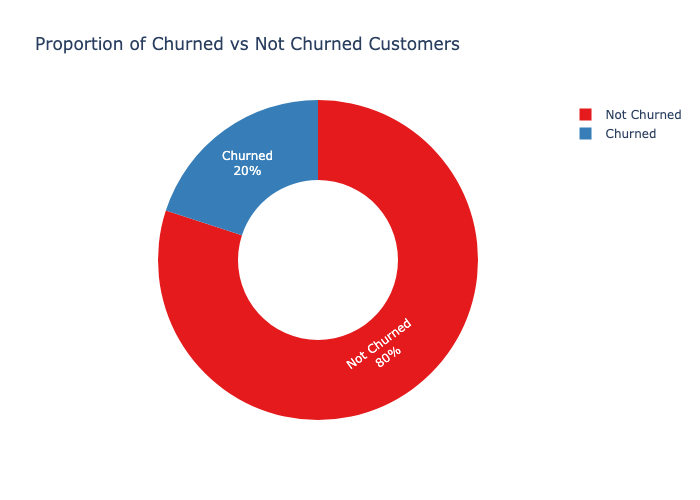

In [7]:
chd_counts = df["churn"].value_counts().sort_index()
labels = ["Not Churned", "Churned"]
fig = px.pie(
    names=labels,
    values=chd_counts.values,
    title="Proportion of Churned vs Not Churned Customers",
    hole=0.5,
    color_discrete_sequence=px.colors.qualitative.Set1,
)
fig.update_traces(textinfo="percent+label")
fig.write_image("plot.png")
display(Image(filename="plot.png"))

Notably, the target variable is imbalanced: the large majority of customers did not churn. While it is positive for the business, this could result in poorer detection of churn, as models are biased toward predicting majority class.

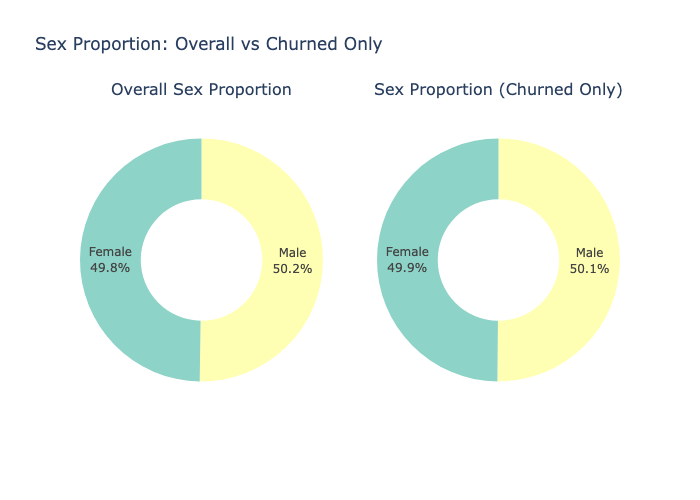

In [8]:
sex_counts = df["gender"].value_counts().sort_index()
sex_labels = ["Female", "Male"]

sex_chd_counts = df[df["churn"] == 1]["gender"].value_counts().sort_index()
sex_chd_labels = ["Female", "Male"]

fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{"type": "domain"}, {"type": "domain"}]],
    subplot_titles=["Overall Sex Proportion", "Sex Proportion (Churned Only)"],
)

fig.add_trace(
    go.Pie(
        labels=sex_labels,
        values=sex_counts.values,
        hole=0.5,
        name="Sex",
        marker_colors=px.colors.qualitative.Set3,
    ),
    1,
    1,
)
fig.add_trace(
    go.Pie(
        labels=sex_chd_labels,
        values=sex_chd_counts.values,
        hole=0.5,
        name="Sex (CHD)",
        marker_colors=px.colors.qualitative.Set3,
    ),
    1,
    2,
)

fig.update_traces(textinfo="percent+label")
fig.update_layout(
    title_text="Sex Proportion: Overall vs Churned Only", showlegend=False)
fig.write_image("plot.png")
display(Image(filename="plot.png"))

Median Age for churn=0: 44.0
Median Age for churn=1: 44.0


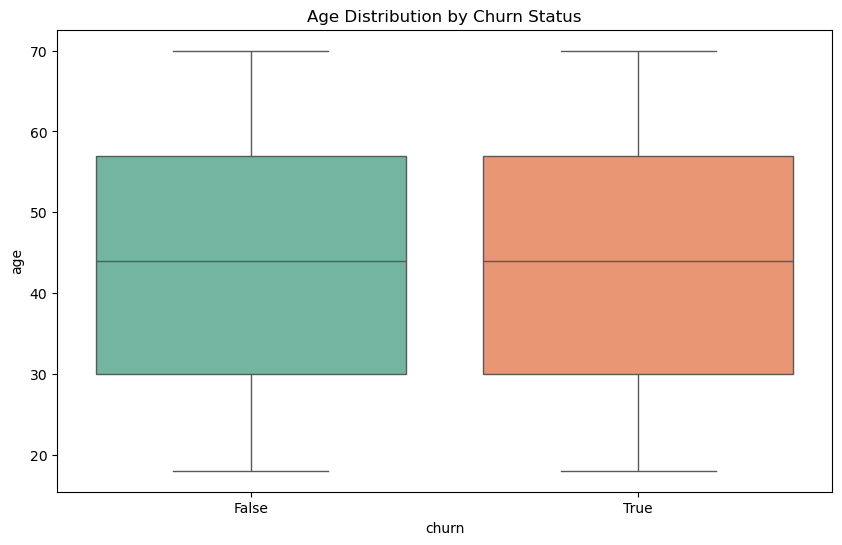

In [9]:
medians = df.groupby("churn")["age"].median()
print("Median Age for churn=0:", medians.iloc[0])
print("Median Age for churn=1:", medians.iloc[1])
plt.figure(figsize=(10, 6))
sns.boxplot(x="churn", y="age", hue="churn", data=df, palette="Set2", legend=False)
plt.title("Age Distribution by Churn Status")
plt.show()

Median Number of Purchases for churn=0: 5.0
Median Number of Purchases for churn=1: 5.0


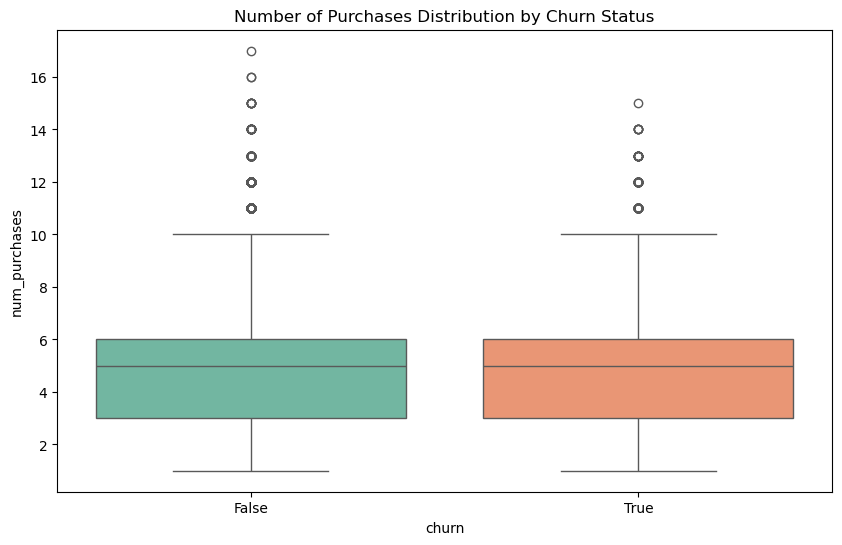

In [10]:
medians = df.groupby("churn")["num_purchases"].median()
print("Median Number of Purchases for churn=0:", medians.iloc[0])
print("Median Number of Purchases for churn=1:", medians.iloc[1])
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="churn", y="num_purchases", hue="churn", data=df, palette="Set2", legend=False
)
plt.title("Number of Purchases Distribution by Churn Status")
plt.show()

Median Number of Returns for churn=0: 2.0
Median Number of Returns for churn=1: 2.0


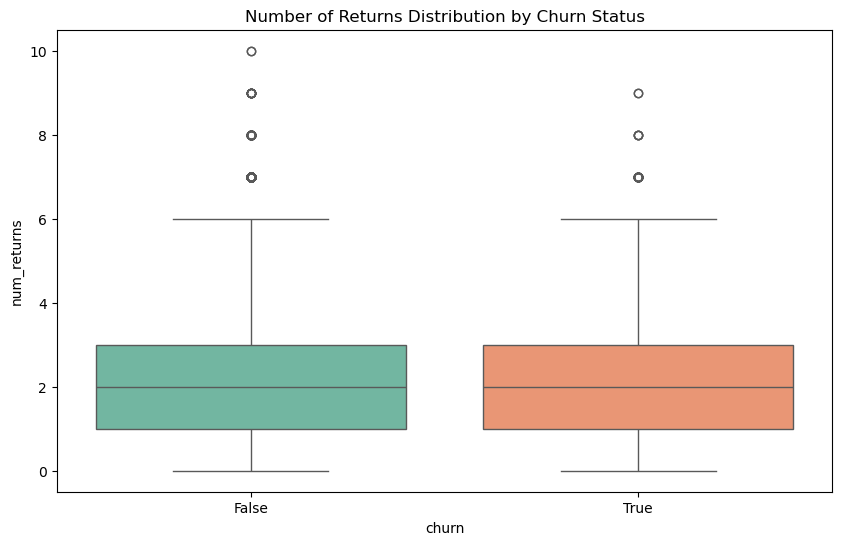

In [11]:
medians = df.groupby("churn")["num_returns"].median()
print("Median Number of Returns for churn=0:", medians.iloc[0])
print("Median Number of Returns for churn=1:", medians.iloc[1])
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="churn", y="num_returns", hue="churn", data=df, palette="Set2", legend=False
)
plt.title("Number of Returns Distribution by Churn Status")
plt.show()

Median Expenditure for churn=0: 12981.0
Median Expenditure for churn=1: 13093.0


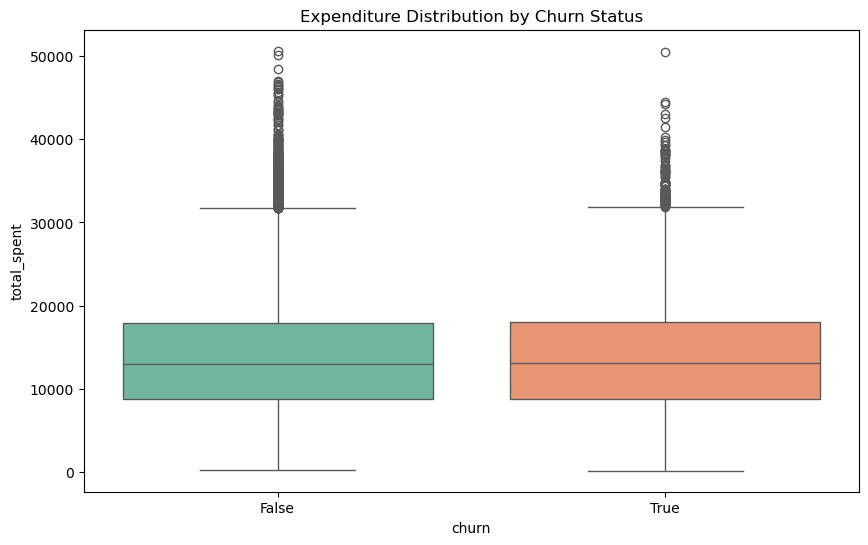

In [12]:
medians = df.groupby("churn")["total_spent"].median()
print("Median Expenditure for churn=0:", medians.iloc[0])
print("Median Expenditure for churn=1:", medians.iloc[1])
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="churn", y="total_spent", hue="churn", data=df, palette="Set2", legend=False
)
plt.title("Expenditure Distribution by Churn Status")
plt.show()

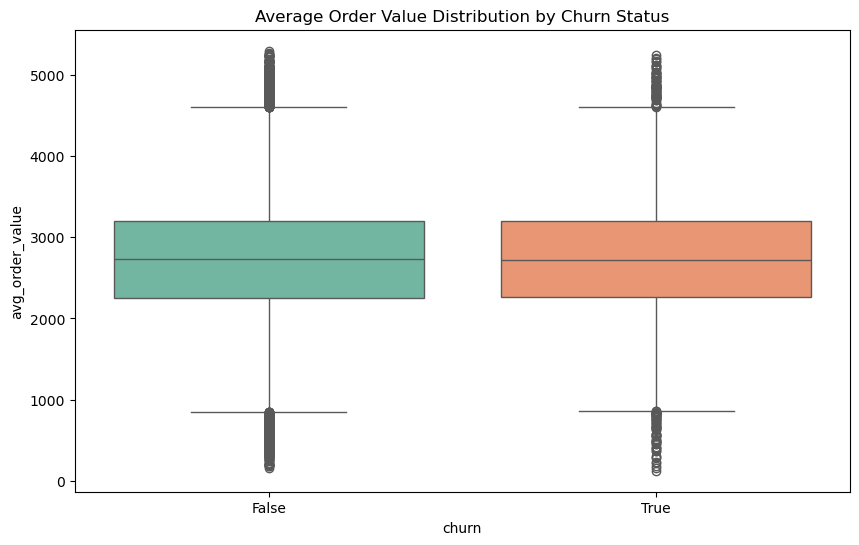

In [13]:
medians = df.groupby("churn")["avg_order_value"].median()
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="churn", y="avg_order_value", hue="churn", data=df, palette="Set2", legend=False
)
plt.title("Average Order Value Distribution by Churn Status")
plt.show()

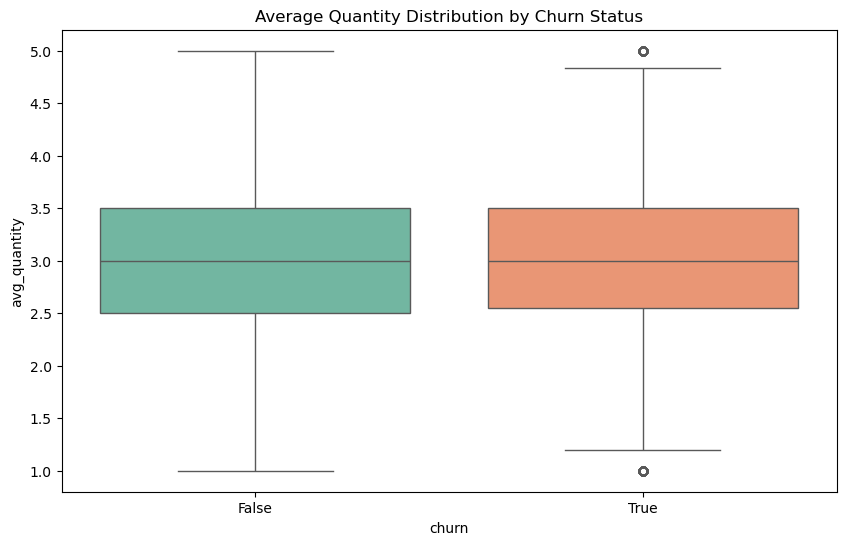

In [14]:
medians = df.groupby("churn")["avg_quantity"].median()
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="churn", y="avg_quantity", hue="churn", data=df, palette="Set2", legend=False
)
plt.title("Average Quantity Distribution by Churn Status")
plt.show()

Median Number of Categories for churn=0: 3.0
Median Number of Categories for churn=1: 3.0


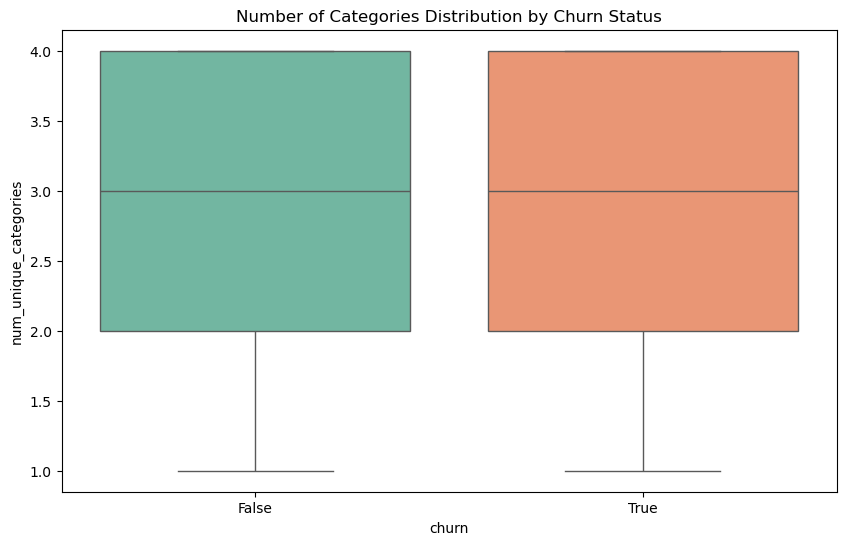

In [15]:
medians = df.groupby("churn")["num_unique_categories"].median()
print("Median Number of Categories for churn=0:", medians.iloc[0])
print("Median Number of Categories for churn=1:", medians.iloc[1])
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="churn",
    y="num_unique_categories",
    hue="churn",
    data=df,
    palette="Set2",
    legend=False,
)
plt.title("Number of Categories Distribution by Churn Status")
plt.show()

Median Number of Payment Methods for churn=0: 3.0
Median Number of Payment Methods for churn=1: 3.0


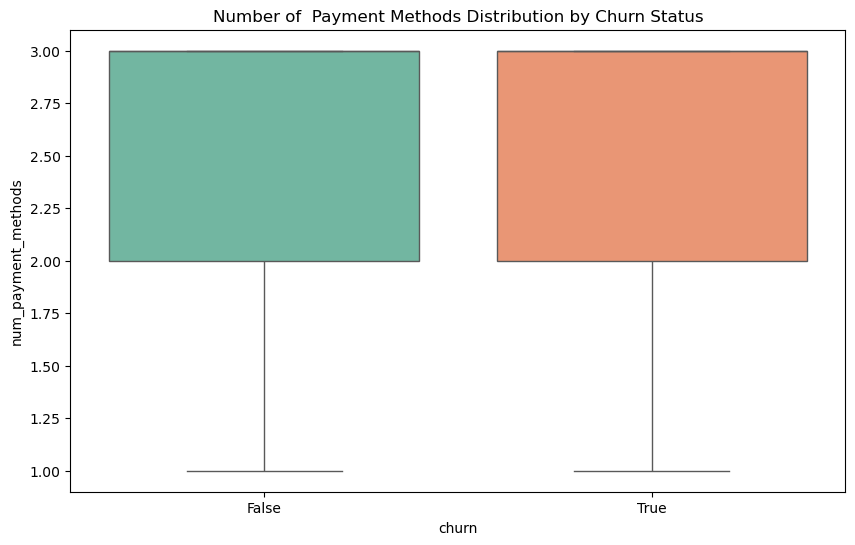

In [16]:
medians = df.groupby("churn")["num_payment_methods"].median()
print("Median Number of Payment Methods for churn=0:", medians.iloc[0])
print("Median Number of Payment Methods for churn=1:", medians.iloc[1])
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="churn",
    y="num_payment_methods",
    hue="churn",
    data=df,
    palette="Set2",
    legend=False,
)
plt.title("Number of  Payment Methods Distribution by Churn Status")
plt.show()

Median Recency for churn=0: 940.0
Median Recency for churn=1: 939.0


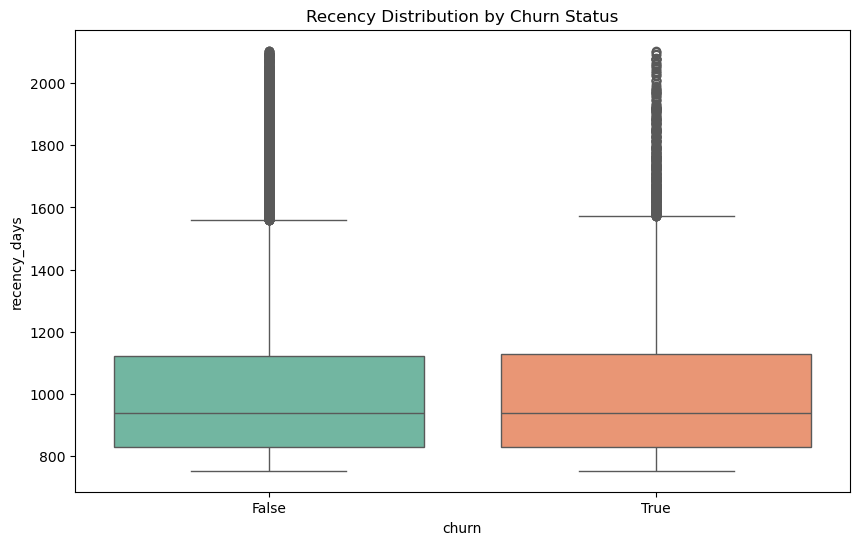

In [17]:
medians = df.groupby("churn")["recency_days"].median()
print("Median Recency for churn=0:", medians.iloc[0])
print("Median Recency for churn=1:", medians.iloc[1])
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="churn", y="recency_days", hue="churn", data=df, palette="Set2", legend=False
)
plt.title("Recency Distribution by Churn Status")
plt.show()

Median Customer Lifetime in Days for churn=0: 900.0
Median Customer Lifetime in Days  for churn=1: 904.0


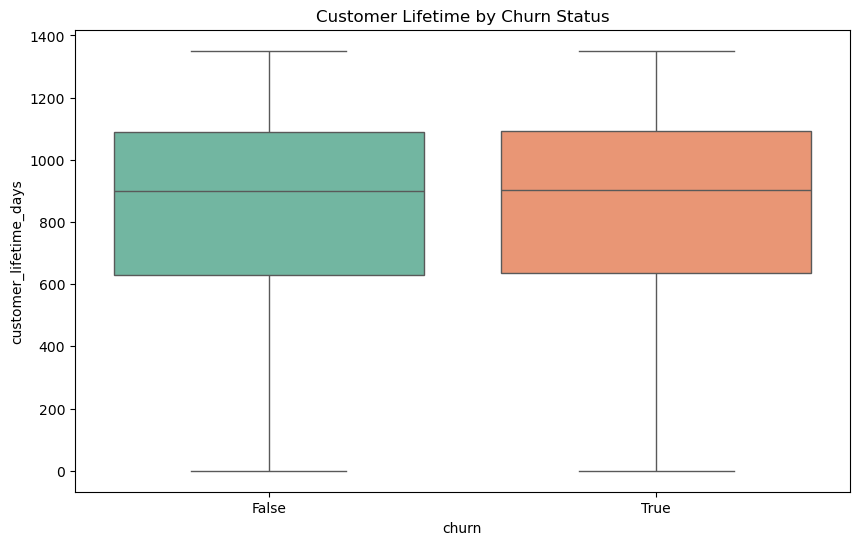

In [18]:
medians = df.groupby("churn")["customer_lifetime_days"].median()
print("Median Customer Lifetime in Days for churn=0:", medians.iloc[0])
print("Median Customer Lifetime in Days  for churn=1:", medians.iloc[1])
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="churn",
    y="customer_lifetime_days",
    hue="churn",
    data=df,
    palette="Set2",
    legend=False,
)
plt.title("Customer Lifetime by Churn Status")
plt.show()

No meaningful differences, perhaps churn/no-churn groups were balanced out in metrics in this synthetic dataset.

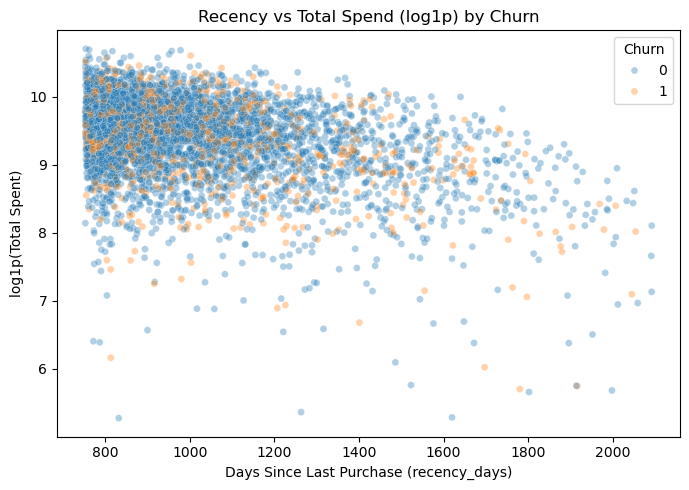

In [19]:
# Scatter plot - looking for potential feature interactions or nonlinear relationships between recency and expenditure
plot_df = df.sample(n=min(5000, len(df)), random_state=42).copy()

plot_df["churn"] = plot_df["churn"].astype(int).astype("category")

plot_df["total_spent_log1p"] = np.log1p(plot_df["total_spent"])

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=plot_df, x="recency_days", y="total_spent_log1p", hue="churn", alpha=0.35, s=25
)
plt.title("Recency vs Total Spend (log1p) by Churn")
plt.xlabel("Days Since Last Purchase (recency_days)")
plt.ylabel("log1p(Total Spent)")
plt.legend(title="Churn", loc="best")
plt.tight_layout()
plt.show()

Somewhat linear – more recent customers spent more. No relationship with churn.

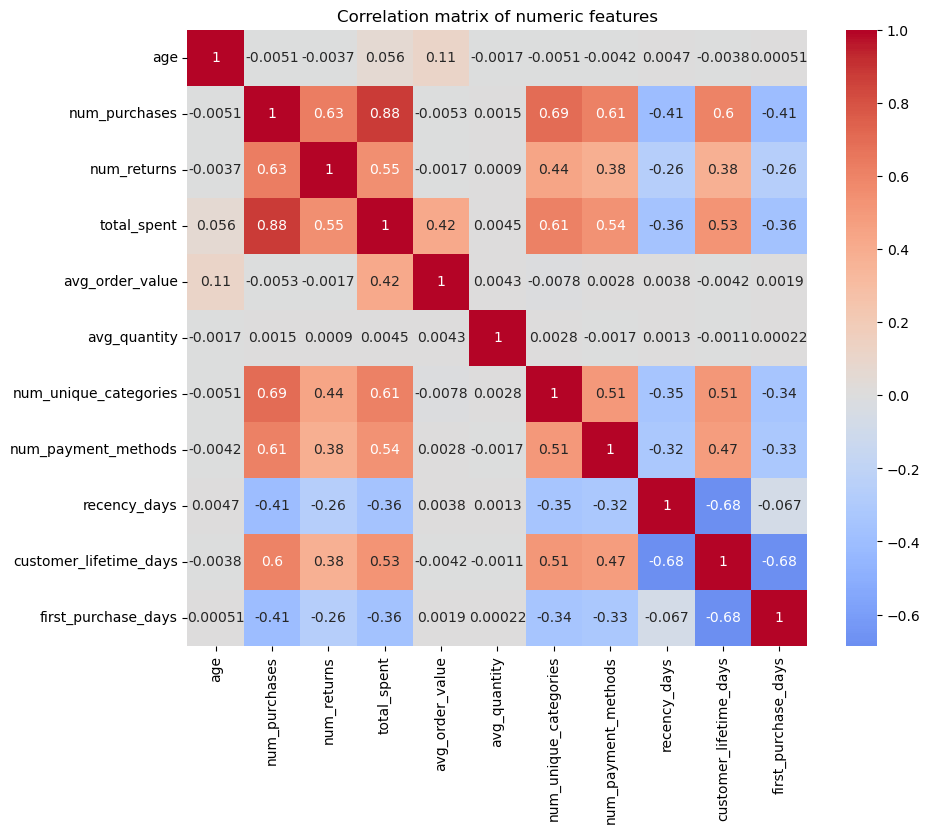

In [20]:
# Checking collinearity
corr = df.select_dtypes(include="number").corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation matrix of numeric features")
plt.show()

Dropping num_purchases since it is highly collerative with many features as well as first_purchase_days because it is redundant when having customer_lifetime_days (r -0.68).	

In [21]:
numeric_features_afterdrop = [
    'age', 'num_returns', 'total_spent', 'avg_order_value',
    'avg_quantity', 'num_unique_categories', 'num_payment_methods',
    'recency_days', 'customer_lifetime_days'
]


X_vif = df[numeric_features_afterdrop].assign(const=1)
vif_df = pd.DataFrame(
    {
        "feature": numeric_features_afterdrop,
        "VIF": [
            variance_inflation_factor(X_vif.values, i)
            for i in range(len(numeric_features_afterdrop))
        ],
    }
)
vif_df

,feature,VIF
0,age,1.013361
1,num_returns,1.594739
2,total_spent,3.451668
3,avg_order_value,1.617380
4,avg_quantity,1.000066
5,num_unique_categories,1.936001
6,num_payment_methods,1.634463
7,recency_days,1.883165
8,customer_lifetime_days,2.511485


All VIF values acceptable (<5) after dropping mentioned columns.

## Pipelines

In [22]:
target = "churn"

categorical_features = ["gender"]
numeric_features = [
    "age",
    "num_returns",
    "total_spent",
    "avg_order_value",
    "avg_quantity",
    "num_unique_categories",
    "num_payment_methods",
    "recency_days",
    "customer_lifetime_days",
]

X = df[categorical_features + numeric_features].copy()
y = df[target].astype(int)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=24
)

num_pipe = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)

cat_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_features),
        ("cat", cat_pipe, categorical_features),
    ],
    remainder="drop",
)

clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        (
            "model",
            LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"),
        ),
    ]
)

In [24]:
# Baseline model for sanity check and whether logistic regression outperforms random chance

models = {
    "Baseline: Majority": DummyClassifier(strategy="most_frequent"),
    "Baseline: Stratified": DummyClassifier(strategy="stratified", random_state=42),
    "Baseline: Uniform": DummyClassifier(strategy="uniform", random_state=42),
    "Logistic Regression": LogisticRegression(
        max_iter=1000, class_weight="balanced", solver="lbfgs"
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

rows = []
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    scores = cross_validate(
        pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score="raise"
    )
    rows.append(
        {
            "Model": name,
            "Accuracy": np.mean(scores["test_accuracy"]),
            "Precision": np.mean(scores["test_precision"]),
            "Recall": np.mean(scores["test_recall"]),
            "F1": np.mean(scores["test_f1"]),
            "ROC AUC": np.mean(scores["test_roc_auc"]),
        }
    )

cv_comparison = pd.DataFrame(rows).sort_values("F1", ascending=False)
print(cv_comparison)

                  Model  Accuracy  Precision    Recall        F1   ROC AUC
2     Baseline: Uniform  0.501077   0.199385  0.495920  0.284419  0.500000
3   Logistic Regression  0.498238   0.196430  0.488267  0.280083  0.492857
1  Baseline: Stratified  0.681863   0.198542  0.194682  0.196593  0.499146
0    Baseline: Majority  0.800064   0.000000  0.000000  0.000000  0.500000


Majority classifier always repredicts majority class (correct here, 80% did not churn). High accuracy irrelevant in this case, since the goal is churn prediction. 
Stratified Baseline predicts according to the observed class distribution and outperforms random chance (Uniform Baseline) only in accuracy.
Logistic Regression performs similarly to random baselines (ROC-AUC ~ 0.49). This indicates the current features set does not provide predictive signal for churn, which was expected from lack of difference in feature distributions betweeen the groups. 

## Fitting the Model (learning purposes)

Confusion Matrix:
 [[3841 4106]
 [1008  978]]

Classification Report:
               precision    recall  f1-score   support

           0      0.792     0.483     0.600      7947
           1      0.192     0.492     0.277      1986

    accuracy                          0.485      9933
   macro avg      0.492     0.488     0.439      9933
weighted avg      0.672     0.485     0.536      9933

ROC AUC: 0.4904901822509676


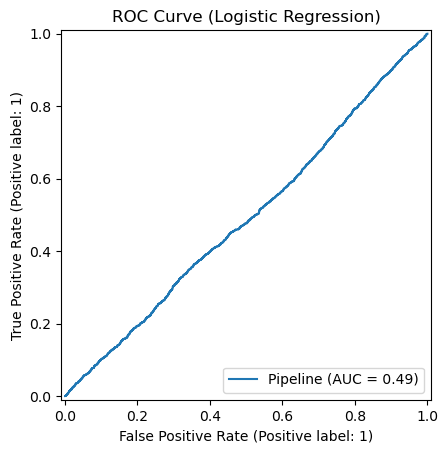

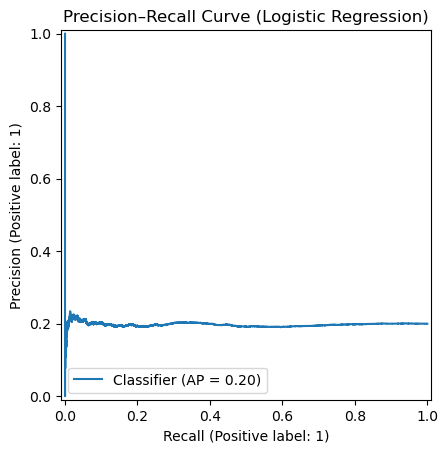

In [25]:
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve (Logistic Regression)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.show()

Confusion matrix shows coin-flip-like predictions of TP and TN. Scores of minority class are lower despite trying adjusts weight (class_weight='balanced').

In [26]:
# Optimizing for F1 (better when interested in minority class, balancing precision and recall)

prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1s = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1s)
best_thr = thr[max(best_idx - 1, 0)]

print(f"Best threshold for F1: {best_thr:.4f}")

y_pred_opt = (y_proba >= best_thr).astype(int)

cm = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix at best threshold:\n", cm)

print(
    "\nClassification Report at best threshold:\n",
    classification_report(y_test, y_pred_opt, digits=3),
)

Best threshold for F1: 0.4736

Confusion Matrix at best threshold:
 [[  13 7934]
 [   1 1985]]

Classification Report at best threshold:
               precision    recall  f1-score   support

           0      0.929     0.002     0.003      7947
           1      0.200     0.999     0.333      1986

    accuracy                          0.201      9933
   macro avg      0.564     0.501     0.168      9933
weighted avg      0.783     0.201     0.069      9933



At best F1, model casts almost everyone as churners, that is, it cannot meaningfully distinguish them. 

In [27]:
# Deriving ORs and feature coefficients
logreg = clf.named_steps["model"]
preprocessor = clf.named_steps["preprocess"]

num_features_out = preprocessor.named_transformers_["num"].get_feature_names_out(
    numeric_features
)
cat_features_out = (
    preprocessor.named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names_out(categorical_features)
)
feature_names = np.concatenate([num_features_out, cat_features_out])

coefs = logreg.coef_.flatten()
odds_ratios = np.exp(coefs)

odds_df = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": coefs, "Odds Ratio": odds_ratios}
).sort_values(by="Odds Ratio", ascending=False)

print("\nIntercept:", np.exp(logreg.intercept_)[0])
print("\nOdds ratios:\n", odds_df.head(10))


Intercept: 1.000395933802032

Odds ratios:
                   Feature  Coefficient  Odds Ratio
8  customer_lifetime_days     0.033223    1.033781
2             total_spent     0.028823    1.029242
7            recency_days     0.020701    1.020917
6     num_payment_methods     0.010394    1.010448
9             gender_Male     0.002322    1.002324
3         avg_order_value    -0.000156    0.999844
0                     age    -0.005288    0.994726
1             num_returns    -0.013863    0.986232
4            avg_quantity    -0.015770    0.984354
5   num_unique_categories    -0.032720    0.967809


All odds ratios ≈ 1.0 (e.g. male gender increases the odds by 0.23%) and β ≈ 0 indicating weak predictive power — consistent with the model’s poor baseline performance.

Results summary:
* Accuracy (0.49) and ROC AUC (0.49) are essentially random. Odds ratios and feature coefficients also show weak and near-neutral effects, reinforcing that the available features carry little to no signal about churn behavior. Churn cannot be explained well by current features. In a real-world (non synthetic dataset) scenario this could indicate limited feature relevance, missing contextual factors or labeling inaccuracies (how is churn defined?).
* The next step would be trying tree-based models, that capture non-linear patterns (e.g., Gradient Boosting, XGBoost, Random Forest) and data improvements. 